In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from skimage import io # 

/home/jay/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
# Parameters
n_iters = 100
n_predict = 72
batch_size = 10
lr = 0.001  # learning_rate

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [4]:
class TrainSet(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        
    def __len__(self):
        return 650
    
    def __getitem__(self, index):
        index += 1
        if index <= 400-36:
            img_name = 'images/DX/Noisy/' + str(index) + '.pgm'
            label_name = 'images/DX/Original/' + str(index) + '.pgm'
        else:
            img_name = 'images/MMM/Noisy/mdb' + str(index+36) + '.pgm'
            label_name = 'images/MMM/Original/mdb' + str(index+36) + '.pgm'
        image = io.imread(img_name)
        label = io.imread(label_name)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

In [5]:
class TestSet(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        
    def __len__(self):
        return 72
    
    def __getitem__(self, index):
        index += 1
        if index <= 36:
            img_name = 'images/DX/Noisy/' + str(index+400-36) + '.pgm'
            label_name = 'images/DX/Original/' + str(index+400-36) + '.pgm'
        else:
            img_name = 'images/MMM/Noisy/mdb' + str(index+650) + '.pgm'
            label_name = 'images/MMM/Original/mdb' + str(index+650) + '.pgm'
        image = io.imread(img_name)
        label = io.imread(label_name)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

In [6]:
trainset = TrainSet(transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = TestSet(transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
from torch import nn
from torch.nn import functional as F

def encode_block(in_f, out_f):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, 5, padding=2),
        nn.MaxPool2d(2),
        nn.ReLU()
    )

def decode_block(in_f, out_f):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, 5, padding=2),
        nn.ReLU(),
        nn.Upsample(scale_factor=2)
    )

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            encode_block(1, 64),
            encode_block(64, 64)
        )
        
        self.decoder = nn.Sequential(
            decode_block(64, 64),
            decode_block(64, 64),
            nn.Conv2d(64, 1, 5, padding=2),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
net = Net()

print(net)

Net(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Upsample(scale_factor=2.0, mode=nearest)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Upsample(scale_factor=2.0, mode=nearest)
    )
    (2): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)


In [8]:
from torch import optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [11]:
net.to(device)
net.train()

for epoch in range(n_iters):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print statistics
        running_loss += loss.item()
        
    print('[%d] loss: %.10f' %
          (epoch + 1, running_loss / i))
    running_loss = 0.0

print('Finising Training')

[1] loss: 0.2456406232
[2] loss: 0.0482442669
[3] loss: 0.0296521301
[4] loss: 0.0235699316
[5] loss: 0.0193806344
[6] loss: 0.0167780181
[7] loss: 0.0147979353
[8] loss: 0.0134912462
[9] loss: 0.0125616873
[10] loss: 0.0116478354
[11] loss: 0.0109638721
[12] loss: 0.0129873029
[13] loss: 0.0101663351
[14] loss: 0.0097085740
[15] loss: 0.0096203964
[16] loss: 0.0094300210
[17] loss: 0.0090889628
[18] loss: 0.0088496468
[19] loss: 0.0087874679
[20] loss: 0.0088150079
[21] loss: 0.0086552687
[22] loss: 0.0081244700
[23] loss: 0.0085297142
[24] loss: 0.0079328725
[25] loss: 0.0077936223
[26] loss: 0.0084617327
[27] loss: 0.0079013042
[28] loss: 0.0090227204
[29] loss: 0.0076546656
[30] loss: 0.0074181151
[31] loss: 0.0073968744
[32] loss: 0.0080931400
[33] loss: 0.0070543898
[34] loss: 0.0070948131
[35] loss: 0.0077475489
[36] loss: 0.0072583974
[37] loss: 0.0068100764
[38] loss: 0.0067795832
[39] loss: 0.0067876954
[40] loss: 0.0069079709
[41] loss: 0.0067508115
[42] loss: 0.0069572988
[

In [40]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from torchvision.utils import make_grid

# functions to show an image

def sample_show(images, labels):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 4))
    image = make_grid(images, nrow=batch_size)
    label = make_grid(labels, nrow=batch_size)
    image = image / 2 + 0.5     # unnormalize
    label = label / 2 + 0.5     # unnormalize
    npimage = image.numpy()
    nplabel = label.numpy()
    ax[0].imshow(np.transpose(npimage, (1, 2, 0)))
    ax[1].imshow(np.transpose(nplabel, (1, 2, 0)))
    plt.show()

torch.Size([10, 1, 64, 64])


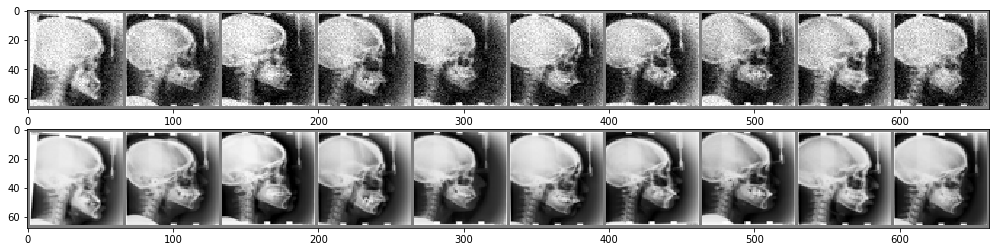

In [42]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
print(images.shape)
sample_show(images, labels)

torch.Size([10, 1, 64, 64])


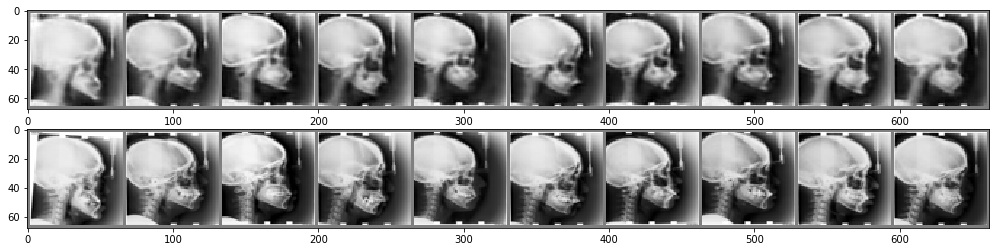

torch.Size([10, 1, 64, 64])


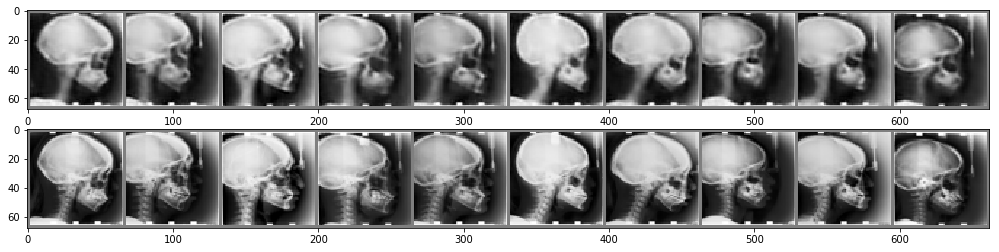

torch.Size([10, 1, 64, 64])


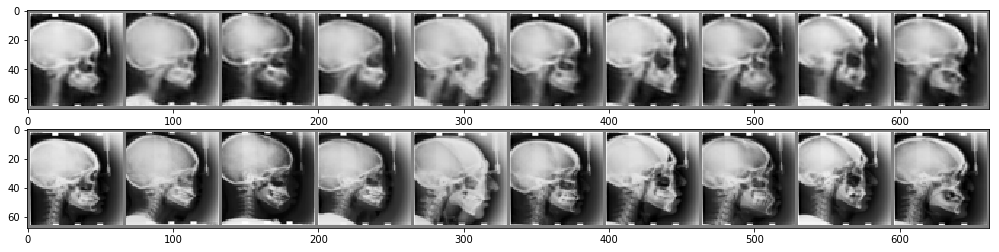

torch.Size([10, 1, 64, 64])


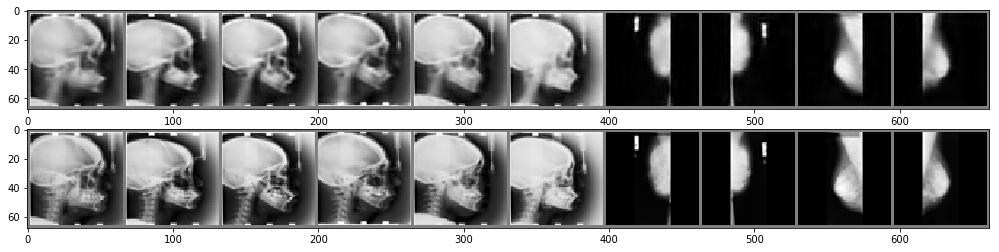

torch.Size([10, 1, 64, 64])


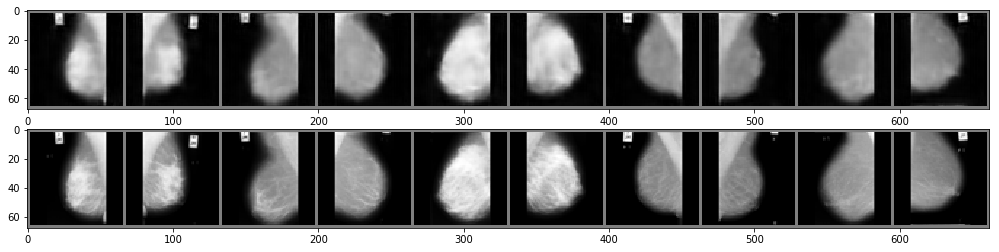

torch.Size([10, 1, 64, 64])


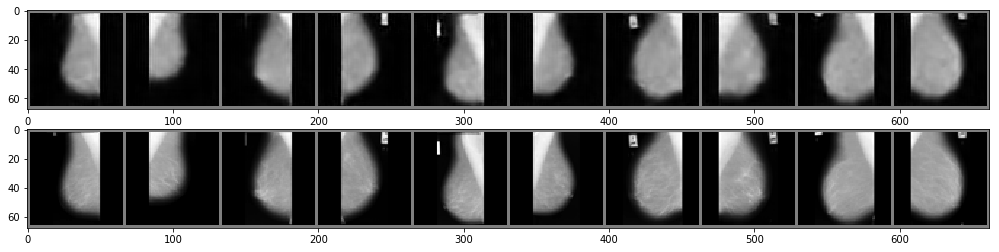

torch.Size([10, 1, 64, 64])


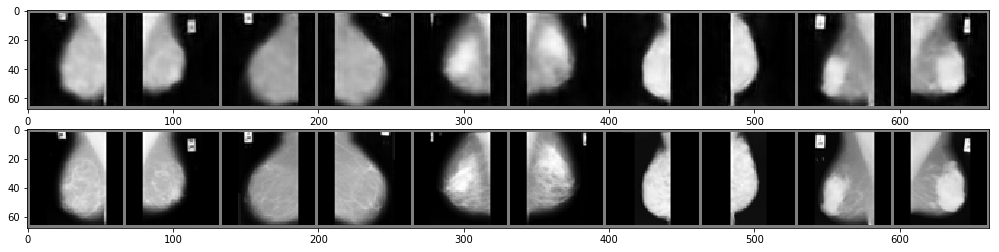

torch.Size([2, 1, 64, 64])


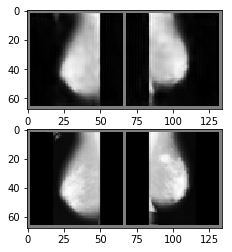

In [43]:
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = torch.clamp(net(images.to(device)).cpu(), min=-1, max=+1)
        print(outputs.shape)
        sample_show(outputs, labels)